In [1]:
# Loading the library to python 
import sys
sys.path.insert(0, "anomaly_detection/")

In [2]:
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

In [ ]:
%matplotlib notebook

# Reading data

In [5]:
def pick_feats(n, w = None, p = None, path_feats = "features"):
    '''Loads the features stored in the folder path_feats.
        Return a dataframe of all networks' features merged '''
    df = pd.DataFrame()
    n_net = 0
    for file in os.listdir(path_feats):
        if file[0] != "G" and (n is None or "n{}_".format(n) in file)\
                          and (w is None or "w{}_".format(w) in file)\
                          and (p is None or "p{}_".format(p) in file):
            df_net = pd.read_pickle(os.path.join(path_feats, file))
            df_net["net_id"] = n_net
            df = df.append(df_net, ignore_index = True)
            n_net += 1
    return df

In [6]:
def split_net(df, test_prop = 0.2):
    '''Split a dataframe of features in two set while keeping each network integrity.
        ie: all nodes of the same network are put in the same dataset (train or test)
    '''
    net_ids = df.net_id.unique()
    n_net = len(net_ids) 
    test_net = np.random.choice(net_ids, int(max(round((test_prop)*n_net), 1)))
    selector = df.net_id.isin(test_net)
    df_train = df.loc[~selector]
    df_test = df.loc[selector]
    return df_train, df_test

In [114]:
df = pick_feats(n = 500)
df = df.replace([np.inf, -np.inf, np.nan], 0)
df.shape

(11500, 90)

In [115]:
df_train, df_test = split_net(df, test_prop=0.2)
df_train = df_train.drop(["w", "n", "p", "net_id"], axis = 1)
df_test = df_test.drop(["w", "n", "p", "net_id"], axis = 1)
df_test.shape, df_train.shape

((2500, 86), (9000, 86))

# Fitting

In [116]:
clf = RandomForestClassifier(n_estimators=100)

In [117]:
clf.fit(df_train.drop("anomaly", axis = 1), df_train.anomaly)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [118]:
Y_test_pred = clf.predict(df_test.drop("anomaly", axis = 1))
Y_test = df_test.anomaly

In [119]:
prec, rec = precision_score(Y_test, Y_test_pred), recall_score(Y_test, Y_test_pred)
print("Score :")
print("\tPrecision : {}".format(prec))
print("\tRecall : {}".format(rec))

Score :
	Precision : 0.7516778523489933
	Recall : 0.16279069767441862


# Features importance

## Top 10 features

In [120]:
feats_imp = pd.Series(clf.feature_importances_, index = df_test.drop("anomaly", axis = 1).columns)

In [121]:
feats_imp.sort_values(ascending=False)[:10]

upper_comb_EXP_g1         0.041595
upper_sym_EXP_g1          0.041502
lower_rw_EXP_g1           0.041040
lower_sym_EXP_g1          0.040822
com_GAW_penalized         0.040339
com_density_rel           0.039666
com_GAW                   0.039560
lower_sym_90ContribAbs    0.039175
com_density_pvalue        0.039094
com_density_penalized     0.033463
dtype: float64

## Features importance by module

In [122]:
feats = pd.Series(df_test.drop("anomaly", axis = 1).columns.values, name="name")
feats = feats.to_frame()

feats["type"] = "Other"

feats.loc[feats["name"].str.contains("^lower_rw_|upper_comb_|lower_sym_|upper_sym_"), "type"] = "loc"
feats.loc[feats["name"].str.contains("^path_size_"), "type"] = "path"
feats.loc[feats["name"].str.contains("^com_"), "type"] = "com"
feats.loc[feats["name"].str.contains("^GAW_"), "type"] = "GAW"

feats["type"] = feats["type"].astype('category')

feats = feats.set_index("name")
feats["imp"] = feats_imp

feats = feats.sort_values("imp", ascending = False)

<IPython.core.display.Javascript object>


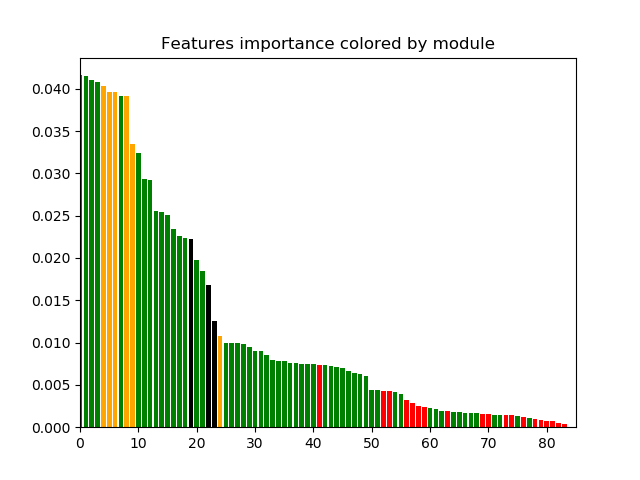

Text(0.5, 1.0, 'Features importance colored by module')

In [123]:
plt.figure()
n_feats = len(feats.imp)
colors = feats["type"].map({"loc" : "green",
                            "path" : "red",
                            "com" : "orange",
                            "GAW" : "black",
                            "Other" : "yellow"})
plt.bar(range(n_feats), feats.imp.values, color = colors)
plt.xlim(0, n_feats)
plt.title("Features importance colored by module")